# Bike Sharing Classification

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm

## 1. Preprocessing

In [2]:
bike_df = pd.read_csv('../data/SeoulBikeData.csv', engine = 'python')

bike_df.columns = ['date', 'bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
                   'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

bike_df['date'] = pd.to_datetime(bike_df['date'], format = '%d/%m/%Y')
bike_df['hour'] = bike_df['hour'].astype('category')
bike_df['season'] = bike_df['season'].astype('category')
bike_df['holiday'] = bike_df['holiday'].astype('category')
bike_df['functioning_day'] = bike_df['functioning_day'].astype('category')
bike_df['day'] = bike_df['date'].dt.day_name().astype('category')
bike_df['class']  = bike_df['bike_count'] > np.median(bike_df['bike_count'])

bike_df = bike_df[bike_df['functioning_day'] == 'Yes']
bike_df = bike_df.drop(['date', 'functioning_day', 'dew_point_temp'], axis = 1)
bike_df = bike_df.reset_index(drop = True)

bike_df.head()

bike_count hour  temperature  humidity  wind_speed  visibility  \
0         254    0         -5.2        37         2.2        2000   
1         204    1         -5.5        38         0.8        2000   
2         173    2         -6.0        39         1.0        2000   
3         107    3         -6.2        40         0.9        2000   
4          78    4         -6.0        36         2.3        2000   

   solar_radiation  rainfall  snowfall  season     holiday     day  class  
0              0.0       0.0       0.0  Winter  No Holiday  Friday  False  
1              0.0       0.0       0.0  Winter  No Holiday  Friday  False  
2              0.0       0.0       0.0  Winter  No Holiday  Friday  False  
3              0.0       0.0       0.0  Winter  No Holiday  Friday  False  
4              0.0       0.0       0.0  Winter  No Holiday  Friday  False

In [3]:
full_df = bike_df

full_ddf = pd.get_dummies(full_df['hour'], drop_first = True, prefix = 'hour:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['day'], drop_first = True, prefix = 'day:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['season'], drop_first = True, prefix = 'season:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['holiday'],  prefix = 'holiday:')], axis = 1)
full_ddf = full_ddf.drop('holiday:_No Holiday', axis = 1)

full_df = full_df.drop(['hour', 'day', 'season', 'holiday', 'bike_count'], axis = 1)

c = bike_df['class']

full_df = full_df.drop('class', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [4]:
random.seed(42)
X_train = X.sample(frac = 0.7).sort_index()
c_train = c[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
c_test = c[~X.index.isin(X_train.index)]

## 2. Clustering Algorithms

### 2.1. K-Means

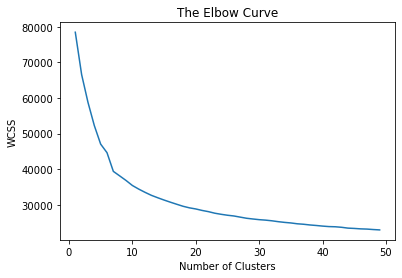

In [5]:
wcss = []
for i in range(1, 50):
    kmeans_arr = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_arr.fit(X)
    wcss.append(kmeans_arr.inertia_)
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [6]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(X)
print('WCSS: {:.2f}'.format(kmeans.inertia_))
print(np.unique(kmeans.labels_, return_counts = True))

WCSS: 35396.50
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1048, 1764,  765,  166,  864, 1473,  816,   19, 1443,  107],
      dtype=int64))


In [7]:
X_kmeans = X.copy()
X_kmeans['cluster'] = kmeans.labels_
X_kmeans = pd.concat([X_kmeans, pd.get_dummies(X_kmeans['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_kmeans = X_kmeans.drop(['cluster'], axis = 1)
X_train_kmeans = X_kmeans[X_kmeans.index.isin(X_train.index)]
X_test_kmeans = X_kmeans[~X_kmeans.index.isin(X_train.index)]

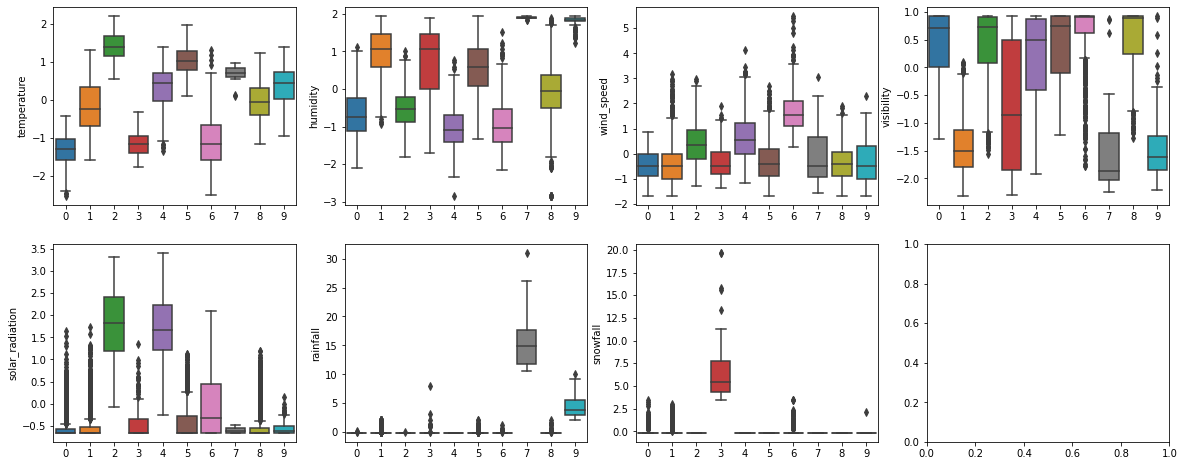

In [8]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
for i, ax in enumerate(zip(['temperature', 'humidity', 'wind_speed', 'visibility', 
                            'solar_radiation', 'rainfall', 'snowfall'], fig.axes)):
    sns.boxplot(y = X[ax[0]], x = kmeans.labels_, ax = ax[1])

In [9]:
bike_df['cluster'] = kmeans.labels_
bike_df.groupby(['cluster', 'class'])['bike_count'].count().reset_index().pivot('cluster', 'class', 'bike_count')

class    False  True 
cluster              
0          937    111
1         1203    561
2            8    757
3          163      3
4           79    785
5          411   1062
6          632    184
7           18      1
8          531    912
9          103      4

#### ANN Model

In [10]:
def nn1_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (49, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc1_model = KerasClassifier(build_fn = nn1_model, batch_size = 10, epochs = 100, verbose = 0)

kmeans_nnc_model = GridSearchCV(estimator = nnc1_model, 
                                param_grid = {'neurons' : nnc_neuron_arr}, 
                                n_jobs = -1, cv = 5, return_train_score = True)

kmeans_nnc_model.fit(X_train_kmeans.values, c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123AAC074F0>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 25}
Best Cross-Validation Accuracy: 0.91
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


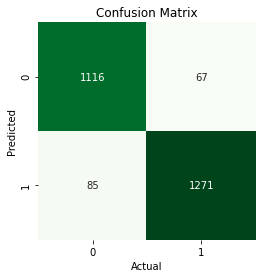

Accuracy: 0.94
Senstivity: 0.95
Specificity: 0.93


In [11]:
print('Best Parameters: {}'.format(kmeans_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(kmeans_nnc_model.best_score_))

pred_kmeans_nnc = kmeans_nnc_model.predict(X_test_kmeans)

cm_kmeans_nnc = confusion_matrix(c_test, pred_kmeans_nnc)
tn, fp, fn, tp = cm_kmeans_nnc.ravel()

ax = sns.heatmap(cm_kmeans_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_kmeans_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### 2.2. Expectation Maximization

In [12]:
em = GaussianMixture(n_components = 10, init_params = 'kmeans', max_iter = 300, n_init = 10, random_state = 0)
em.fit(X)
em_means = em.means_
print(np.unique(em.predict(X), return_counts = True))

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64), array([ 172,  692,   72, 2056, 1200,  134,   82, 2292,  626, 1139],
      dtype=int64))


In [13]:
X_em = X.copy()
X_em['cluster'] = em.predict(X)
X_em = pd.concat([X_em, pd.get_dummies(X_em['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_em = X_em.drop(['cluster'], axis = 1)
X_train_em = X_em[X_em.index.isin(X_train.index)]
X_test_em = X_em[~X_em.index.isin(X_train.index)]

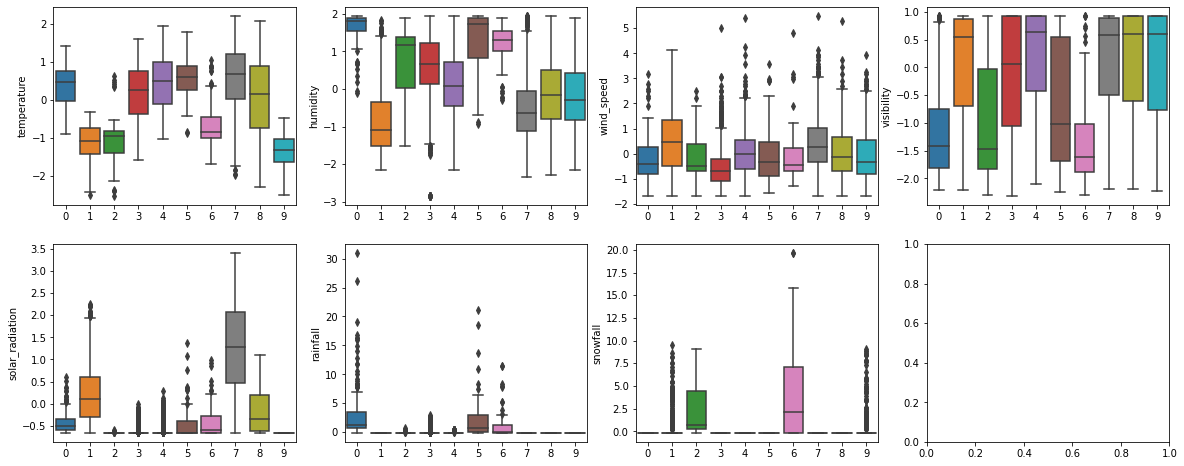

In [14]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
for i, ax in enumerate(zip(['temperature', 'humidity', 'wind_speed', 'visibility', 
                            'solar_radiation', 'rainfall', 'snowfall'], fig.axes)):
    sns.boxplot(y = X[ax[0]], x = em.predict(X), ax = ax[1])

In [15]:
bike_df['cluster'] = em.predict(X)
bike_df.groupby(['cluster', 'class'])['bike_count'].count().reset_index().pivot('cluster', 'class', 'bike_count')

class    False  True 
cluster              
0          152     20
1          669     23
2           58     14
3         1407    649
4          112   1088
5           95     39
6           68     14
7          280   2012
8          113    513
9         1131      8

#### ANN Model

In [16]:
def nn2_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (49, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc2_model = KerasClassifier(build_fn = nn2_model, batch_size = 10, epochs = 100, verbose = 0)

em_nnc_model = GridSearchCV(estimator = nnc2_model, 
                            param_grid = {'neurons' : nnc_neuron_arr}, 
                            n_jobs = -1, cv = 5, return_train_score = True)

em_nnc_model.fit(X_train_em.values, c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123AAF45190>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 10}
Best Cross-Validation Accuracy: 0.91


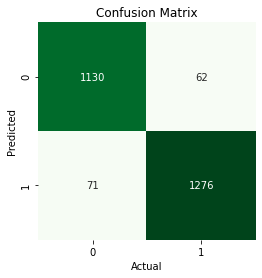

Accuracy: 0.95
Senstivity: 0.95
Specificity: 0.94


In [17]:
print('Best Parameters: {}'.format(em_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(em_nnc_model.best_score_))

pred_em_nnc = em_nnc_model.predict(X_test_em)

cm_em_nnc = confusion_matrix(c_test, pred_em_nnc)
tn, fp, fn, tp = cm_em_nnc.ravel()

ax = sns.heatmap(cm_em_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_em_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## 3. Dimensionality Reduction Techniques

### 3.1. Random Forest

In [18]:
random.seed(0)

rf = RandomForestClassifier() 
rf.fit(X_train, c_train.values.ravel()) 
# rf.score(Xf_test, y_test)

pd.DataFrame({'feature' : [i.split(':', 1)[0] for i in X_train.columns], 
              'importance' : rf.feature_importances_}).groupby('feature').sum().sort_values('importance', ascending = False)

importance
feature                    
temperature        0.238940
hour               0.221591
season             0.174046
humidity           0.101825
solar_radiation    0.076247
visibility         0.049075
wind_speed         0.045246
day                0.042867
rainfall           0.036526
snowfall           0.009651
holiday            0.003986

In [19]:
top_var_list = ['temperature', 'hour', 'season', 'humidity', 'solar_radiation']

top_df = bike_df[top_var_list]
top_ddf = pd.get_dummies(top_df['hour'], drop_first = True, prefix = 'hour:')
top_ddf = pd.concat([top_ddf, pd.get_dummies(top_df['season'], drop_first = True, prefix = 'season:')], axis = 1)

top_df = top_df.drop(['hour', 'season'], axis = 1)

X_rf = pd.concat([featureNormalize(top_df), top_ddf], axis = 1).reset_index(drop = True)

In [20]:
X_train_rf = X_rf[X_rf.index.isin(X_train.index)]
X_test_rf = X_rf[~X_rf.index.isin(X_train.index)]

#### ANN Model

In [21]:
def nn3_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (29, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc3_model = KerasClassifier(build_fn = nn3_model, batch_size = 10, epochs = 100, verbose = 0)

rf_nnc_model = GridSearchCV(estimator = nnc3_model, 
                            param_grid = {'neurons' : nnc_neuron_arr}, 
                            n_jobs = -1, cv = 5, return_train_score = True)

rf_nnc_model.fit(X_train_rf.values, c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123B81F1EE0>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 30}
Best Cross-Validation Accuracy: 0.90


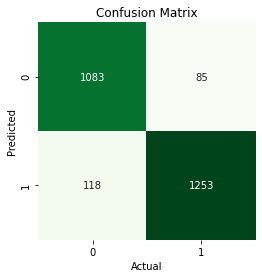

Accuracy: 0.92
Senstivity: 0.94
Specificity: 0.90


In [22]:
print('Best Parameters: {}'.format(rf_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(rf_nnc_model.best_score_))

pred_rf_nnc = rf_nnc_model.predict(X_test_rf)

cm_rf_nnc = confusion_matrix(c_test, pred_rf_nnc)
tn, fp, fn, tp = cm_rf_nnc.ravel()

ax = sns.heatmap(cm_rf_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_rf_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### 3.2. Principal Component Analysis

In [23]:
pca = PCA(random_state = 0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
np.round(pca.explained_variance_ratio_ * 100, 2)

array([2.300e+01, 1.649e+01, 1.166e+01, 9.890e+00, 8.200e+00, 6.770e+00,
       2.550e+00, 2.510e+00, 1.560e+00, 1.550e+00, 1.540e+00, 1.520e+00,
       1.460e+00, 6.800e-01, 5.300e-01, 4.700e-01, 4.700e-01, 4.700e-01,
       4.700e-01, 4.600e-01, 4.600e-01, 4.600e-01, 4.600e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.400e-01, 4.400e-01, 4.400e-01,
       4.400e-01, 4.300e-01, 4.300e-01, 4.300e-01, 4.300e-01, 4.200e-01,
       2.900e-01, 2.200e-01, 1.400e-01, 2.000e-02])

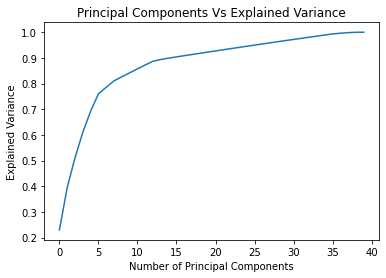

In [24]:
plt.plot(range(len(pca.explained_variance_ratio_ )), np.cumsum(pca.explained_variance_ratio_))
plt.title('Principal Components Vs Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

In [25]:
labels = {
    str(i): f"PC {i + 1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(X_train_pca, labels = labels, dimensions = range(6), color = c_train)
fig.update_traces(diagonal_visible = False)
fig.update_layout(autosize = False, width = 900, height = 900)
fig.show()

#### ANN Model

In [26]:
def nn4_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (13, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc4_model = KerasClassifier(build_fn = nn4_model, batch_size = 10, epochs = 100, verbose = 0)

pca_nnc_model = GridSearchCV(estimator = nnc4_model, 
                             param_grid = {'neurons' : nnc_neuron_arr}, 
                             n_jobs = -1, cv = 5, return_train_score = True)

pca_nnc_model.fit(X_train_pca[:,:13], c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123BAF31A30>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 5}
Best Cross-Validation Accuracy: 0.82


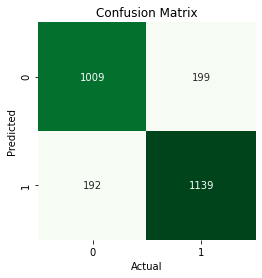

Accuracy: 0.85
Senstivity: 0.85
Specificity: 0.84


In [27]:
print('Best Parameters: {}'.format(pca_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(pca_nnc_model.best_score_))

pred_pca_nnc = pca_nnc_model.predict(X_test_pca[:,:13])

cm_pca_nnc = confusion_matrix(c_test, pred_pca_nnc)
tn, fp, fn, tp = cm_pca_nnc.ravel()

ax = sns.heatmap(cm_pca_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_pca_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### 3.3. Independent Component Analysis

In [28]:
ica = FastICA(max_iter = 1000, random_state = 0)
X_train_ica = ica.fit_transform(X_train)
X_train_ica_df = pd.DataFrame(X_train_ica)
X_test_ica = ica.transform(X_test)

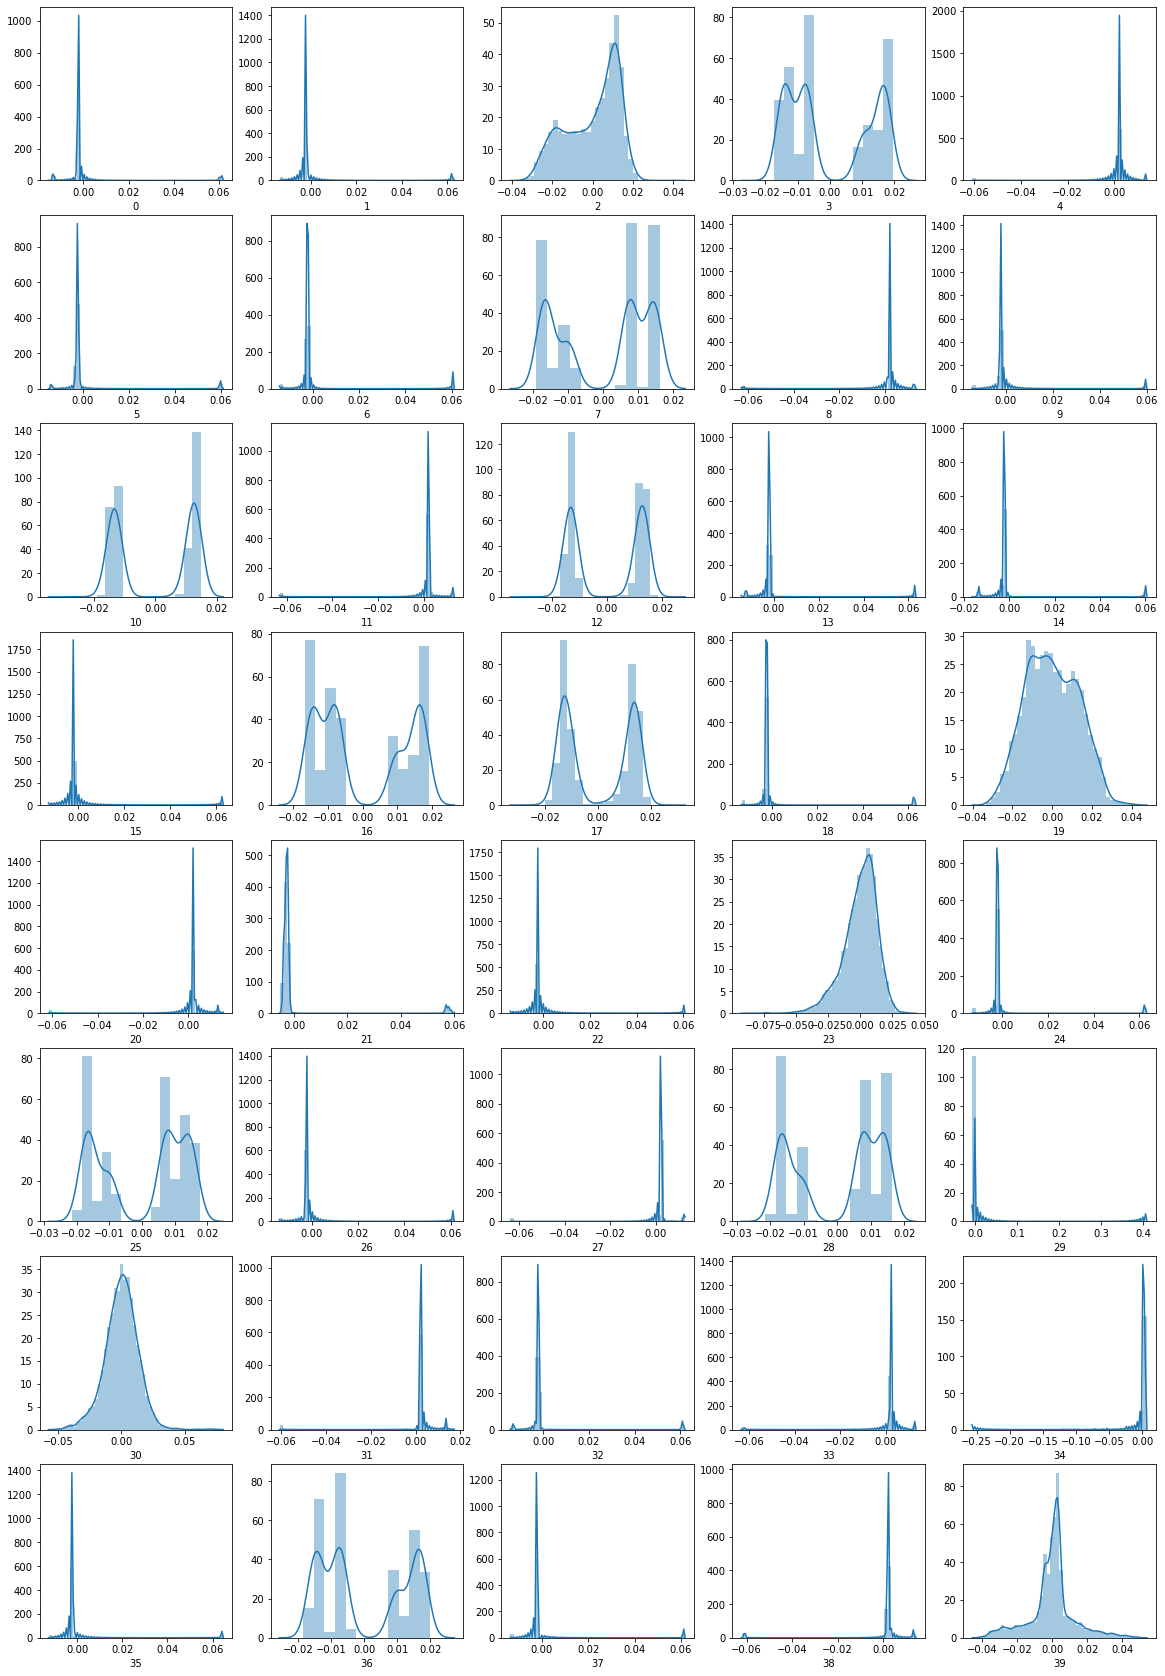

In [29]:
fig, axes = plt.subplots(nrows = 8, ncols = 5, figsize = (20, 30))
for i, ax in enumerate(zip(X_train_ica_df.columns, fig.axes)):
    sns.distplot(X_train_ica_df[ax[0]], ax = ax[1])

### 3.4. Random Projection

In [30]:
rp = GaussianRandomProjection(random_state = 0, n_components = 13)
X_train_rp = rp.fit_transform(X_train)
X_test_rp = rp.transform(X_test)

#### ANN Model

In [31]:
def nn6_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (13, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc6_model = KerasClassifier(build_fn = nn6_model, batch_size = 10, epochs = 100, verbose = 0)

rp_nnc_model = GridSearchCV(estimator = nnc6_model, 
                             param_grid = {'neurons' : nnc_neuron_arr}, 
                             n_jobs = -1, cv = 5, return_train_score = True)

rp_nnc_model.fit(X_train_rp, c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123B58A1850>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 30}
Best Cross-Validation Accuracy: 0.85


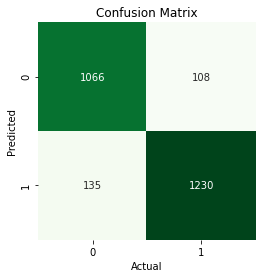

Accuracy: 0.90
Senstivity: 0.92
Specificity: 0.89


In [32]:
print('Best Parameters: {}'.format(rp_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(rp_nnc_model.best_score_))

pred_rp_nnc = rp_nnc_model.predict(X_test_rp)

cm_rp_nnc = confusion_matrix(c_test, pred_rp_nnc)
tn, fp, fn, tp = cm_rp_nnc.ravel()

ax = sns.heatmap(cm_rp_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_rp_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## 4. Cluster Analysis on Dimensionality Reduction Algorithms

### 4.1. k-Means on Features Selected using Random Forest

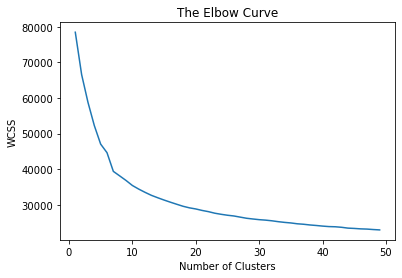

In [33]:
wcss_rf = []
for i in range(1, 50):
    kmeans_arr = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_arr.fit(X_rf)
    wcss_rf.append(kmeans_arr.inertia_)
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [34]:
kmeans_rf = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans_rf.fit(X_rf)
print('WCSS: {:.2f}'.format(kmeans_rf.inertia_))
print(np.unique(kmeans_rf.labels_, return_counts = True))

WCSS: 13387.44
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 896,  727,  830, 1059, 1217,  944,  469, 1005,  597,  721],
      dtype=int64))


In [35]:
X_kmeans_rf = X_rf.copy()
X_kmeans_rf['cluster'] = kmeans_rf.labels_
X_kmeans_rf = pd.concat([X_kmeans_rf, 
                         pd.get_dummies(X_kmeans_rf['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_kmeans_rf = X_kmeans_rf.drop(['cluster'], axis = 1)
X_train_kmeans_rf = X_kmeans_rf[X_kmeans_rf.index.isin(X_train.index)]
X_test_kmeans_rf = X_kmeans_rf[~X_kmeans_rf.index.isin(X_train.index)]

#### ANN Model

In [36]:
def nn7_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (38, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc7_model = KerasClassifier(build_fn = nn7_model, batch_size = 10, epochs = 100, verbose = 0)

kmeans_rf_nnc_model = GridSearchCV(estimator = nnc7_model, 
                             param_grid = {'neurons' : nnc_neuron_arr}, 
                             n_jobs = -1, cv = 5, return_train_score = True)


kmeans_rf_nnc_model.fit(X_train_kmeans_rf.values, c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123BD9A0C10>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 15}
Best Cross-Validation Accuracy: 0.89


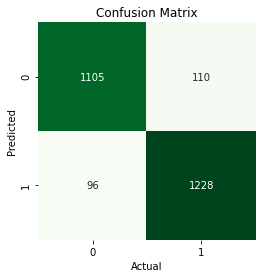

Accuracy: 0.92
Senstivity: 0.92
Specificity: 0.92


In [37]:
print('Best Parameters: {}'.format(kmeans_rf_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(kmeans_rf_nnc_model.best_score_))

pred_kmeans_rf_nnc = kmeans_rf_nnc_model.predict(X_test_kmeans_rf)

cm_kmeans_rf_nnc = confusion_matrix(c_test, pred_kmeans_rf_nnc)
tn, fp, fn, tp = cm_kmeans_rf_nnc.ravel()

ax = sns.heatmap(cm_kmeans_rf_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_kmeans_rf_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### 4.2. k-Means on PCA Features

In [38]:
pca2 = PCA(random_state = 0)
X_kmeans_pca = pca2.fit_transform(X)
np.round(pca2.explained_variance_ratio_ * 100, 2)

array([2.306e+01, 1.642e+01, 1.152e+01, 9.880e+00, 8.290e+00, 6.750e+00,
       2.600e+00, 2.520e+00, 1.580e+00, 1.550e+00, 1.530e+00, 1.520e+00,
       1.480e+00, 6.800e-01, 5.300e-01, 4.600e-01, 4.500e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.400e-01,
       2.800e-01, 2.200e-01, 1.400e-01, 2.000e-02])

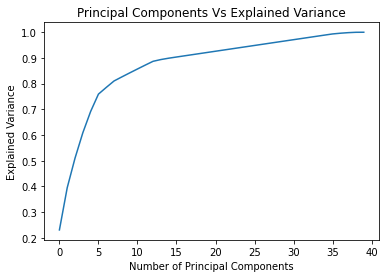

In [39]:
plt.plot(range(len(pca2.explained_variance_ratio_ )), np.cumsum(pca2.explained_variance_ratio_))
plt.title('Principal Components Vs Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

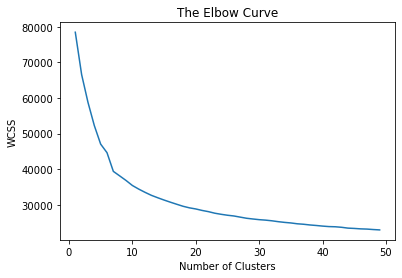

In [40]:
wcss_pca = []
for i in range(1, 50):
    kmeans_arr = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_arr.fit(X_kmeans_pca[:,:13])
    wcss_rf.append(kmeans_arr.inertia_)
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [41]:
kmeans_pca = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans_pca.fit(X_kmeans_pca[:,:13])
print('WCSS: {:.2f}'.format(kmeans_pca.inertia_))
print(np.unique(kmeans_pca.labels_, return_counts = True))

WCSS: 26519.67
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1477,  587, 1510, 1356,  823,  167,   20, 1011, 1394,  120],
      dtype=int64))


In [42]:
X_kmeans_pca_df = pd.DataFrame(X_kmeans_pca[:,:13])
X_kmeans_pca_df['cluster'] = kmeans_pca.labels_
X_kmeans_pca_df = pd.concat([X_kmeans_pca_df, 
                          pd.get_dummies(X_kmeans_pca_df['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_kmeans_pca_df = X_kmeans_pca_df.drop(['cluster'], axis = 1)
X_train_kmeans_pca = X_kmeans_pca_df[X_kmeans_pca_df.index.isin(X_train.index)]
X_test_kmeans_pca = X_kmeans_pca_df[~X_kmeans_pca_df.index.isin(X_train.index)]

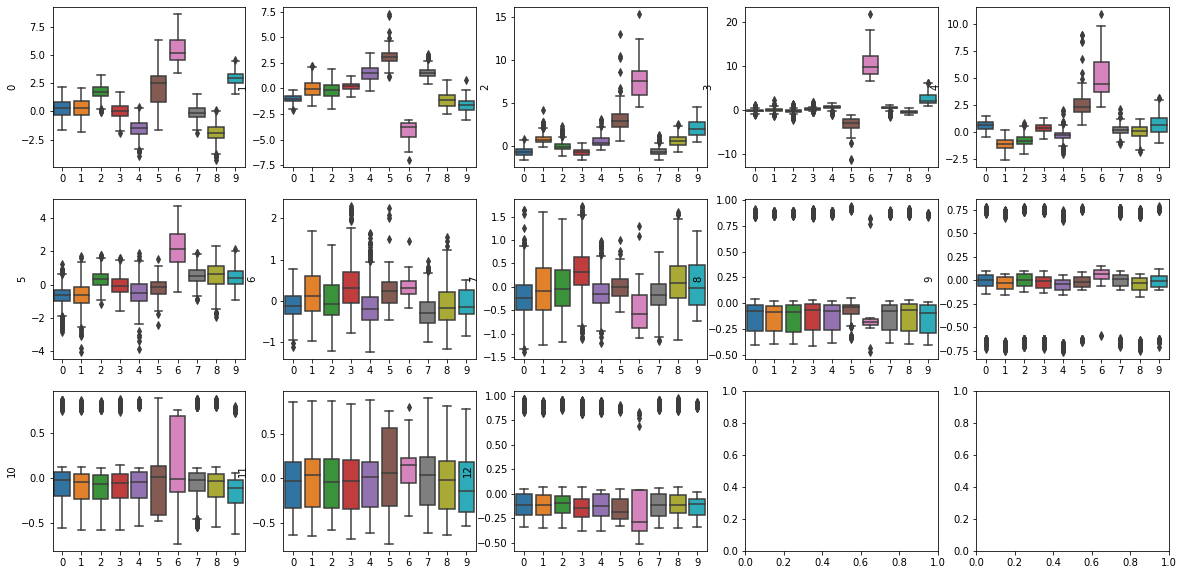

In [43]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (20, 10))
for i, ax in enumerate(zip(X_kmeans_pca_df.iloc[:,:13].columns.values, fig.axes)):
    sns.boxplot(y = X_kmeans_pca_df[ax[0]], x = kmeans_pca.labels_, ax = ax[1])

#### ANN Model

In [44]:
def nn8_model(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (22, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(lr = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics= ['accuracy'])
    return model

nnc_neuron_arr = [1, 5, 10, 15, 20, 25, 30]

nnc8_model = KerasClassifier(build_fn = nn8_model, batch_size = 10, epochs = 100, verbose = 0)

kmeans_pca_nnc_model = GridSearchCV(estimator = nnc8_model, 
                                    param_grid = {'neurons' : nnc_neuron_arr}, 
                                    n_jobs = -1, cv = 5, return_train_score = True)

kmeans_pca_nnc_model.fit(X_train_kmeans_pca, c_train.values.ravel())

GridSearchCV(cv=5,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x00000123C1C183A0>,
             n_jobs=-1, param_grid={'neurons': [1, 5, 10, 15, 20, 25, 30]},
             return_train_score=True)

Best Parameters: {'neurons': 30}
Best Cross-Validation Accuracy: 0.82


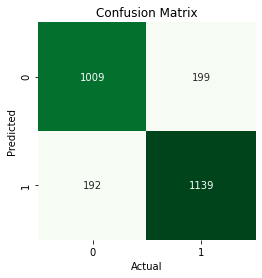

Accuracy: 0.87
Senstivity: 0.85
Specificity: 0.84


In [45]:
print('Best Parameters: {}'.format(kmeans_pca_nnc_model.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(kmeans_pca_nnc_model.best_score_))

pred_kmeans_pca_nnc = kmeans_pca_nnc_model.predict(X_test_kmeans_pca)

cm_kmeans_pca_nnc = confusion_matrix(c_test, pred_pca_nnc)
tn, fp, fn, tp = cm_kmeans_pca_nnc.ravel()

ax = sns.heatmap(cm_kmeans_pca_nnc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_kmeans_pca_nnc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))